#    **NLI-PT Experiments**

In [ ]:
#Install SHAP
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 575 kB 14.7 MB/s 


In [ ]:
# Import libraries
import csv
import shap
import pylab
import numpy as np
import pandas as pd
import seaborn as sns
from numpy import std
from numpy import mean
from sklearn import svm
from sklearn import metrics
from sklearn.svm import SVC
import scipy.stats as stats
from scipy.stats import kstest
from google.colab import files
from collections import Counter
from scipy.stats import shapiro
from scipy.stats import spearmanr
from sklearn import preprocessing
from scipy.stats import normaltest
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# **Statistical Analysis**

In [ ]:
# Read data
df = pd.read_csv("NLI-PT_newest22.csv", encoding= 'unicode_escape')

In [ ]:
# List all features
features = df.columns[:-1].tolist()
for i in features:
  print (i)

Cohesive Complexity Feature: Mendes Additive Connectives per Token
Cohesive Complexity Feature: Mendes All Connectives per Token
Cohesive Complexity Feature: Mendes Causal Connectives per Token
Cohesive Complexity Feature: Mendes Concessive Connectives per Token
Cohesive Complexity Feature: Mendes Other Connectives per Token
Cohesive Complexity Feature: Mendes Single-Word Connectives per Connective
Cohesive Complexity Feature: Mendes Single-Word Connectives per Token
Cohesive Complexity Feature: Mendes Temporal Connectives per Token
Dependency Locality Theory: High Adjacent IC at Finite Verb (original cost configuration)
Dependency Locality Theory: Maximal IC at Finite Verb (higher verb weight)
Dependency Locality Theory: Maximal IC at Finite Verb (less coordination weight + higher verb weight)
Dependency Locality Theory: Maximal IC at Finite Verb (less coordination weight)
Dependency Locality Theory: Maximal IC at Finite Verb (no modifier weight + less coordination weight + added verb

* **Verify normal distribution**

In [ ]:
for i in features:
  shapiro(df[i])
  stat, p = shapiro(df[i])
  alpha = 0.05
  if p > alpha:
    print(i + ' Sample looks Gaussian (fail to reject H0)')

Lexical Sophistication Feature: SUBTLEX Logarithmic Contextual Diversity (SD LW Token) Sample looks Gaussian (fail to reject H0)
Lexical Sophistication Feature: SUBTLEX Logarithmic Contextual Diversity (SD LW Type) Sample looks Gaussian (fail to reject H0)
Lexical Sophistication Feature: SUBTLEX Logarithmic Word Frequency (N Token) Sample looks Gaussian (fail to reject H0)
Lexical Sophistication Feature: SUBTLEX Logarithmic Word Frequency (SD LW Token) Sample looks Gaussian (fail to reject H0)
Lexical Sophistication Feature: Portuguese Vocabulary Profile A1 Sample looks Gaussian (fail to reject H0)


In [ ]:
alpha = 0.05
for i in features:  
  normaltest(df[i])
  stat, p = normaltest(df[i])
  if p > alpha:
    print(i + ' looks Gaussian (fail to reject H0)')

Lexical Sophistication Feature: SUBTLEX Contextual Diversity (LW Type) looks Gaussian (fail to reject H0)
Lexical Sophistication Feature: SUBTLEX Contextual Diversity (SD AW Token) looks Gaussian (fail to reject H0)
Lexical Sophistication Feature: SUBTLEX Logarithmic Contextual Diversity (SD LW Token) looks Gaussian (fail to reject H0)
Lexical Sophistication Feature: SUBTLEX Logarithmic Contextual Diversity (SD LW Type) looks Gaussian (fail to reject H0)
Lexical Sophistication Feature: SUBTLEX Logarithmic Word Frequency (N Token) looks Gaussian (fail to reject H0)
Lexical Sophistication Feature: SUBTLEX Logarithmic Word Frequency (SD LW Token) looks Gaussian (fail to reject H0)
Morphological Complexity Inflection Feature: Indicatives per Verb looks Gaussian (fail to reject H0)
Syntactic Complexity Feature: Dependent clauses per T-unit looks Gaussian (fail to reject H0)
Lexical Sophistication Feature: Portuguese Vocabulary Profile A1 looks Gaussian (fail to reject H0)


* **Inspect Q-Q plots**

((array([-3.497638  , -3.25363685, -3.11868965, ...,  3.11868965,
          3.25363685,  3.497638  ]),
  array([0.34693878, 0.37837838, 0.38461538, ..., 0.81632653, 0.82142857,
         0.88372093])),
 (0.06408372346829438, 0.6007818698684615, 0.9996274993269253))

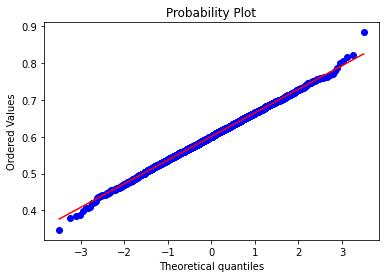

In [ ]:
stats.probplot(df['Lexical Sophistication Feature: Portuguese Vocabulary Profile A1'], dist="norm", plot=pylab)

((array([-3.497638  , -3.25363685, -3.11868965, ...,  3.11868965,
          3.25363685,  3.497638  ]), array([ 0,  0,  0, ..., 33, 35, 45])),
 (3.736870772472838, 4.26176769387064, 0.9123471605424766))

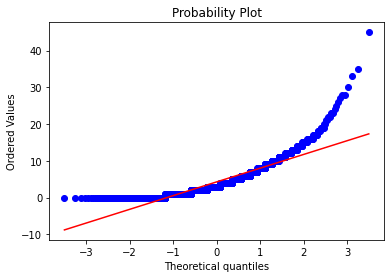

In [ ]:
stats.probplot(df['Number of Syntactic Constituents: Null Subject'], dist="norm", plot=pylab)

Only 9 features are normally distributed. This calls for a non-parametric analysis of variation.

* **Perform Kruskal-Wallis test + Episolon Squared test**

In [ ]:
# Only print moderate, relatively strong, strong and very strong effect sizes
for i in features:  
  data = [df.loc[ids, i].values for ids in df.groupby('Proficiency').groups.values()]
  H, p = stats.kruskal(*data)
  temp_df = pd.DataFrame().assign(ord=df[i],nom=df['Proficiency'])
  n = len(temp_df)
  esq = H * (n+1) / (n ** 2 -1)
  if esq >.04 and esq < .16:
    print(i + ': Moderate effect: ' , esq)
  if esq > .16 and esq < .36:
    print(i + ': Relatively strong effect ',esq)
  if esq > .36 and esq < .64:
    print(i + ': Strong effect: ',esq)  
  if esq > .64:
    print(i + ': Very strong effect: ',esq)  

Lexical Richness: Type Token Ratio (10 Segments): Moderate effect:  0.11276309444860791
Lexical Richness: Type Token Ratio (Corrected TTR Adjectives): Moderate effect:  0.11399886828045859
Lexical Richness: Type Token Ratio (Corrected TTR Adverbs): Moderate effect:  0.11916468012797368
Lexical Richness: Type Token Ratio (Corrected TTR Lexical Words): Relatively strong effect  0.16902773121679662
Lexical Richness: Type Token Ratio (Corrected TTR Nouns): Moderate effect:  0.09530622242433318
Lexical Richness: Type Token Ratio (Corrected TTR Verbs): Moderate effect:  0.1589297453225755
Lexical Richness: Type Token Ratio (Corrected TTR Words): Relatively strong effect  0.16731227797390924
Lexical Richness: Type Token Ratio (Corrected TTR): Moderate effect:  0.1599201829423682
Lexical Richness: Type Token Ratio (Root TTR Adjectives): Moderate effect:  0.11404786137396096
Lexical Richness: Type Token Ratio (Root TTR Adverbs): Moderate effect:  0.11918475392938443
Lexical Richness: Type Token

# **Machine Learning Experiments**

(The best hyperparameters were found using GridSearch,  cf. NLI-PT_gridsearch_crossval.py)

In [ ]:
# Separate dependent and independent variables
X = df.iloc[:, :-1].values
y = df.iloc[:, 464].values

* **Verify which scaling method performs best**

In [ ]:
X = MinMaxScaler().fit_transform(X)

In [ ]:
X = RobustScaler().fit_transform(X)

In [ ]:
X = StandardScaler().fit_transform(X) #BEST RESULTS

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40, shuffle=True)

* **SVM Classifier**

In [ ]:
svm_model = SVC(C=2.5, kernel='rbf', probability=True)

In [ ]:
# 10-fold cross-validation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42) #C = 2.5
scores = cross_val_score(svm_model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean Accuracy: 0.705 (0.023)


In [ ]:
# 10-fold cross-validation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42) # C = 2.5
scores = cross_val_score(svm_model, X, y, scoring='f1_weighted', cv=cv, n_jobs=-1)
print('Weighted F1: %.3f (%.3f)' % (mean(scores), std(scores)))

Weighted F1: 0.688 (0.023)


In [ ]:
# Experiment with held-out test set (20% of data)
svm_model.fit(X_train, y_train)

SVC(C=2.5, probability=True)

In [ ]:
predictions = svm_model.predict(X_test)

In [ ]:
print(metrics.classification_report(y_test, predictions))

              precision    recall  f1-score   support

           1       0.76      0.82      0.79       263
           2       0.70      0.77      0.73       248
           3       0.72      0.33      0.45        80

    accuracy                           0.73       591
   macro avg       0.73      0.64      0.66       591
weighted avg       0.73      0.73      0.72       591



In [ ]:
print(metrics.confusion_matrix(y_test, predictions))

[[219  41   3]
 [ 51 178  19]
 [ 19  32  29]]


* **Random Forest Classifier**

In [ ]:
rf = RandomForestClassifier(max_depth=15, n_estimators=200, random_state=0)

In [ ]:
# 10-fold cross-validation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
scores = cross_val_score(rf, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean Accuracy: 0.681 (0.023)


In [ ]:
# 10-fold cross-validation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
scores = cross_val_score(rf, X, y, scoring='f1_weighted', cv=cv, n_jobs=-1)
print('Weighted F1: %.3f (%.3f)' % (mean(scores), std(scores)))

Weighted F1: 0.688 (0.023)


In [ ]:
# Experiment with held-out test set
rf.fit(X_train, y_train)
predictions = rf.predict(X_test)

In [ ]:
print(metrics.classification_report(y_test, predictions))

              precision    recall  f1-score   support

         1.0       0.71      0.86      0.78       183
         2.0       0.62      0.70      0.66       172
         3.0       0.82      0.12      0.21        74

    accuracy                           0.67       429
   macro avg       0.71      0.56      0.55       429
weighted avg       0.69      0.67      0.63       429



In [ ]:
print(metrics.confusion_matrix(y_test, predictions))

[[157  26   0]
 [ 49 121   2]
 [ 16  49   9]]


* **Logistic Regression Classifier**

In [ ]:
logisticRegr = LogisticRegression(multi_class='multinomial', solver='lbfgs', C=0.01)# For multiclass problems, only 'newton-cg', 'sag', 'saga' and 'lbfgs' handle multinomial loss;

In [ ]:
# # 10-fold cross-validation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
scores = cross_val_score(logisticRegr, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean Accuracy: 0.683 (0.029)


In [ ]:
# # 10-fold cross-validation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
scores = cross_val_score(logisticRegr, X, y, scoring='f1_weighted', cv=cv, n_jobs=-1)
print('Weighted F1: %.3f (%.3f)' % (mean(scores), std(scores)))

Weighted F1: 0.688 (0.023)


In [ ]:
# Experiment with held-out test set
logisticRegr.fit(X_train, y_train)

LogisticRegression(C=0.01, multi_class='multinomial')

In [ ]:
predictions = logisticRegr.predict(X_test)

In [ ]:
print(metrics.classification_report(y_test, predictions)) #C=0.01

              precision    recall  f1-score   support

           1       0.75      0.80      0.78       263
           2       0.68      0.72      0.70       248
           3       0.52      0.31      0.39        80

    accuracy                           0.70       591
   macro avg       0.65      0.61      0.62       591
weighted avg       0.69      0.70      0.69       591



In [ ]:
print(metrics.confusion_matrix(y_test, predictions))

[[211  45   7]
 [ 53 179  16]
 [ 16  39  25]]


* **Account for Imbalanced Data**

In [ ]:
df['Proficiency'].value_counts()

1    1299
2    1197
3     457
Name: Proficiency, dtype: int64

* **Balance data by oversampling**

In [ ]:
# Oversample training samples for each class
over_sampler = RandomOverSampler(random_state=42)
X_res, y_res = over_sampler.fit_resample(X_train, y_train)
print(f"Training target statistics: {Counter(y_res)}")
print(f"Testing target statistics: {Counter(y_test)}")

Training target statistics: Counter({3: 1036, 1: 1036, 2: 1036})
Testing target statistics: Counter({1: 263, 2: 248, 3: 80})


In [ ]:
svm_model = SVC(C=5, gamma='scale', kernel='rbf')
svm_model.fit(X_res, y_res)

SVC(C=5)

In [ ]:
predictions = svm_model.predict(X_test)

In [ ]:
print(metrics.classification_report(y_test, predictions))

              precision    recall  f1-score   support

           1       0.75      0.83      0.79       263
           2       0.71      0.69      0.70       248
           3       0.56      0.41      0.47        80

    accuracy                           0.71       591
   macro avg       0.67      0.64      0.65       591
weighted avg       0.71      0.71      0.71       591



In [ ]:
print(metrics.confusion_matrix(y_test, predictions))

[[218  42   3]
 [ 54 171  23]
 [ 19  28  33]]


* **Balance data by undersampling**

In [ ]:
under_sampler = RandomUnderSampler(random_state=42)
X_res, y_res = under_sampler.fit_resample(X, y)
print(f"Training target statistics: {Counter(y_res)}")

Training target statistics: Counter({1: 457, 2: 457, 3: 457})


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=40, shuffle=True)

In [ ]:
svm_model = SVC(C=5, coef0=0.5, degree=3, gamma='scale', kernel='rbf')
svm_model.fit(X_train, y_train)

SVC(C=5, coef0=0.5)

In [ ]:
predictions = svm_model.predict(X_test)

In [ ]:
print(metrics.classification_report(y_test, predictions)) # Only training data was undersampled

              precision    recall  f1-score   support

           1       0.74      0.73      0.73       263
           2       0.69      0.54      0.61       248
           3       0.34      0.57      0.43        80

    accuracy                           0.63       591
   macro avg       0.59      0.62      0.59       591
weighted avg       0.66      0.63      0.64       591



In [ ]:
print(metrics.classification_report(y_test, predictions)) # Undersampling in whole data set

              precision    recall  f1-score   support

           1       0.64      0.68      0.66        90
           2       0.56      0.61      0.59        93
           3       0.65      0.55      0.60        92

    accuracy                           0.61       275
   macro avg       0.62      0.62      0.61       275
weighted avg       0.62      0.61      0.61       275



In [ ]:
print(metrics.confusion_matrix(y_test, predictions))

[[61 15 14]
 [22 57 14]
 [12 29 51]]


# **Feature Selection with WEKA**

* **Features selected by InfoGain in descending order**

In [ ]:
infogain_df = df[['Number of Word Types with More Than 2 Syllables',
'Lexical Sophistication Feature: Imageability (AW Type)',
'Number of syllables',
'Lexical Sophistication Feature: Imageability (LW Type)',
'Number Of Letters',
'Lexical Sophistication Feature: SUBTLEX Word Frequency per Million (AW Type)',
'Lexical Sophistication Feature: Age of Acquisition (LW Type)',
'Number of Unique Words',
'Number of Word Types (including Punctuation and Numbers)',
'Number of Word Types (excluding Punctuation and numbers)',
'Lexical Sophistication Feature: Concreteness (AW Type)',
'Lexical Sophistication Feature: Concreteness (LW Type)',
'Number of Word Types',
'Number of Tokens',
'Number of Word Tokens (excluding punctuation and numbers)',
'Lexical Variation Feature: Squared Verb Variation 1',
'Lexical Variation Feature: Corrected Verb Variation 1',
'Number of Tokens with More Than 2 Syllables',
'Lexical Sophistication Feature: SUBTLEX Word Frequency per Million (SD AW Type)',
'Number of Word Tokens (including Punctuation and Numbers)',
'Lexical Richness: Type Token Ratio (Root TTR Lexical Words)',
'Lexical Richness: Type Token Ratio (Corrected TTR Lexical Words)',
'Lexical Sophistication Feature: Portuguese Vocabulary Profile B1',
'Lexical Sophistication Feature: Imageability (AW Token)',
'Lexical Richness: Type Token Ratio (Root TTR Words)',
'Lexical Richness: Type Token Ratio (Corrected TTR Words)',
'Lexical Sophistication Feature: Imageability (LW Token)',
'Lexical Sophistication Feature: Concreteness (LW Token)',
'Lexical Richness: Type Token Ratio (Root TTR)',
'Lexical Richness: Type Token Ratio (Corrected TTR)',
'Lexical Richness: Type Token Ratio (Root TTR Verbs)',
'Lexical Richness: Type Token Ratio (Corrected TTR Verbs)',
'Mean Sentence Length in Letters',
'Lexical Sophistication Feature: Concreteness (AW Token)',
'Lexical Sophistication Feature: SUBTLEX Logarithmic Word Frequency (AW Type)',
'Morphological Complexity Inflection Feature: First Person per word token',
'Lexical Richness: Type Token Ratio (STTR Lexical Words)',
'Number of Connectives: Mendes Single-Word Connectives',
'Number of Connectives: Mendes All Connectives',
'Percentage of Word Types with More Than 2 Syllables',
'Lexical Richness: Type Token Ratio (STTR)',
'Lexical Richness: Type Token Ratio (STTR Words)',
'Mean Sentence Length in Syllables',
'Lexical Richness: Type Token Ratio (STTR Nouns)',
'Morphological Complexity Inflection Feature: Subjunctives per verb token',
'Morphological Complexity Inflection Feature: Subjunctives per word token',
'Syntactic Complexity Feature: Dependent clauses per T-unit',
'Lexical Sophistication Feature: Familiarity (AW Type)',
'Syntactic Complexity Feature: Dependent clauses per Sentence',
'Syntactic Complexity Feature: Subordinate Clauses per Sentence',
'Lexical Sophistication Feature: Familiarity (AW Token)',
'Syntactic Complexity Feature: Dependent clause ratio',
'Syntactic Complexity Feature: Relative Clauses per Sentence',
'SD Left Embeddedness',
'Lexical Sophistication Feature: SUBTLEX Word Frequency per Million (FW Type)',
'Lexical Sophistication Feature: Age of Acquisition (LW Token)',
'Lexical Sophistication Feature: Age of Acquisition (AW Token)',
'Lexical Sophistication Feature: Familiarity (LW Token)',
'Morphological Complexity Inflection Feature: Indicatives per Verb',
'Mean Sentence Length in Tokens',
'Syntactic Complexity Feature: Relative Clauses per T-Unit',
'Mean Left Embeddedness',
'Lexical Sophistication Feature: SUBTLEX Contextual Diversity (AW Type)',
'Syntactic Complexity Feature: Relative Clauses per Clause',
'Lexical Sophistication Feature: Familiarity (LW Type)',
'Morphological Complexity Inflection Feature: Nominative Case per Token',
'Syntactic Complexity Feature: Noun Phrases per Sentence',
'Lexical Richness: Type Token Ratio (STTR Adjectives)',
'Syntactic Complexity: Complementizer Phrase Per Sentence',
'Lexical Sophistication Feature: SUBTLEX Word Frequency per Million (SD Adv Type)',
'Mean Global Edit Distance for tokens',
'Lexical Richness: Type Token Ratio (10 Segments)',
'Morphological Complexity Inflection Feature: Indicatives per word token',
'Lexical Sophistication Feature: SUBTLEX Contextual Diversity (SD Adv Type)',
'Lexical Richness: Type Token Ratio (Root TTR Adverbs)',
'Lexical Richness: Type Token Ratio (Corrected TTR Adverbs)',
'Lexical Sophistication Feature: SUBTLEX Logarithmic Contextual Diversity (AW Type)',
'SD Sentence Length in Letters',
'SD Token Length in Letters',
'Lexical Sophistication Feature: SUBTLEX Word Frequency per Million (SD LW Type)',
'Lexical Sophistication Feature: SUBTLEX Logarithmic Contextual Diversity (SD Adv Type)',
'Lexical Richness: Type Token Ratio (STTR Verbs)',
'Morphological Complexity Inflection Feature: Present Subjunctive Verb per Verb Token',
'Lexical Richness: Type Token Ratio (Corrected TTR Adjectives)',
'Lexical Richness: Type Token Ratio (Root TTR Adjectives)',
'SD Sentence Length in Syllables',
'Lexical Sophistication Feature: SUBTLEX Logarithmic Contextual Diversity (SD Adv Token)',
'Lexical Sophistication Feature: SUBTLEX Frequency Top 6000 and Below',
'Lexical Sophistication Feature: SUBTLEX Logarithmic Word Frequency (FW Type)',
'Lexical Sophistication Feature: SUBTLEX Contextual Diversity (SD AW Token)',
'Lexical Sophistication Feature: SUBTLEX Word Frequency per Million (V Type)',
'Lexical Sophistication Feature: SUBTLEX Logarithmic Contextual Diversity (Adv Type)',
'Mean Token Length in Syllables',
'Lexical Richness: Type Token Ratio (Root TTR Nouns)',
'Lexical Richness: Type Token Ratio (Corrected TTR Nouns)',
'Lexical Sophistication Feature: SUBTLEX Logarithmic Word Frequency (SD AW Token)',
'Lexical Sophistication Feature: SUBTLEX Word Frequency per Million (SD FW Token)',
'Lexical Sophistication Feature: SUBTLEX Logarithmic Word Frequency (V Type)',
'Referential Cohesion: Global Lemma Overlap',
'Referential Cohesion: Global Noun Overlap (lemma-based)',
'Lexical Sophistication Feature: SUBTLEX Logarithmic Word Frequency (SD Adv Token)',
'Syntactic Complexity Feature: Adjectival Clause per Sentence',
'Mean Token Length in Letters',
'Referential Cohesion: SD of Global Argument Overlap (lemma-based)',
'Morphological Complexity Inflection Feature: Any Person per word token.1',
'Syntactic Complexity Feature: Complex Nominals per Sentence',
'Lexical Sophistication Feature: SUBTLEX Word Frequency per Million (LW Type)',
'Lexical Sophistication Feature: SUBTLEX Logarithmic Word Frequency (LW Type)',
'Lexical Richness: Type Token Ratio (STTR Adverbs)',
'SD Sentence Length in Tokens',
'Lexical Sophistication Feature: SUBTLEX Contextual Diversity (SD Adv Token)',
'Lexical Sophistication Feature: SUBTLEX Word Frequency per Million (SD FW Type)',
'Mean Global Edit Distance for Lemmas',
'Lexical Sophistication Feature: SUBTLEX Logarithmic Contextual Diversity (V Type)',
'Mean Local Edit Distance for tokens',
'Syntactic Complexity Feature: Sentence Complexity Ratio',
'Syntactic Complexity Feature: Adverbial Clause per Sentence',
'Mean Local Edit Distance for Lemmas',
'POS Density Feature: Cardinal Number',
'Lexical Sophistication Feature: SUBTLEX Contextual Diversity (Adv Type)',
'Referential Cohesion: Global Noun Overlap (word form-based)',
'Lexical Sophistication Feature: SUBTLEX Contextual Diversity (LW Type)',
'Lexical Sophistication Feature: SUBTLEX Logarithmic Contextual Diversity (V Token)',
'Lexical Sophistication Feature: SUBTLEX Logarithmic Contextual Diversity (AW Token)',
'Syntactic Complexity Feature: Sentence Coordination Ratio',
'Syntactic Complexity Feature: Verb Phrases per Sentence',
'Syntactic Complexity Feature: Complex T-unit per Sentence',
'Lexical Sophistication Feature: Portuguese Vocabulary Profile B2',
'Lexical Sophistication Feature: SUBTLEX Contextual Diversity (V Type)',
'Lexical Sophistication Feature: SUBTLEX Logarithmic Contextual Diversity (Adv Token)',
'Lexical Sophistication Feature: SUBTLEX Logarithmic Contextual Diversity (LW Type)',
'Lexical Sophistication Feature: SUBTLEX Logarithmic Word Frequency (SD Adv Type)',
'Lexical Sophistication Feature: SUBTLEX Logarithmic Contextual Diversity (SD V Token)',
'Lexical Sophistication Feature: SUBTLEX Frequency Band 3',
'Lexical Sophistication Feature: SUBTLEX Word Frequency per Million (SD AW Token)',
'Lexical Sophistication Feature: Portuguese Vocabulary Profile A2',
'Lexical Sophistication Feature: SUBTLEX Logarithmic Contextual Diversity (LW Token)',
'Lexical Sophistication Feature: SUBTLEX Logarithmic Word Frequency (SD V Token)',
'Morphological Complexity Inflection Feature: Passive verbs per verb token',
'Morphological Complexity Inflection Feature: Third Person per word token',
'Lexical Sophistication Feature: SUBTLEX Logarithmic Word Frequency (Adv Type)',
'Lexical Sophistication Feature: SUBTLEX Logarithmic Contextual Diversity (SD V Type)',
'SD Token Length in Syllables',
'Referential Cohesion: Global Lexical Overlap (lemma-based)',
'Lexical Sophistication Feature: SUBTLEX Contextual Diversity (LW Token)',
'Syntactic Complexity Feature: Clausal Subjects per Sentence',
'Mean Global Edit Distance for POS',
'Syntactic Complexity Feature: Prepositional Phrases per Sentence',
'Lexical Sophistication Feature: SUBTLEX Frequency Band 2',
'Syntactic Complexity: Passive Sentences Per Sentence',
'Syntactic Complexity Feature: Inverse Order (VS) per Sentence',
'Lexical Sophistication Feature: SUBTLEX Contextual Diversity (Adv Token)',
'Lexical Sophistication Feature: SUBTLEX Logarithmic Word Frequency (AW Token)',
'Lexical Sophistication Feature: Complex Word',
'Syntactic Complexity Feature: Clausal Complements per Sentence',
'Mean Local Edit Distance for POS',
'Referential Cohesion: Mean Global Argument Overlap (lemma-based)',
'Lexical Sophistication Feature: SUBTLEX Logarithmic Word Frequency (LW Token)',
'Lexical Sophistication Feature: SUBTLEX Contextual Diversity (V Token)',
'Syntactic Complexity Feature: Verb Phrases per Clause',
'Morphological Complexity Inflection Feature: Infinite Verb Density',
'Morphological Complexity Inflection Feature: Past Participle Verb Density',
'Lexical Sophistication Feature: SUBTLEX Logarithmic Contextual Diversity (SD AW Token)',
'Lexical Sophistication Feature: SUBTLEX Contextual Diversity (AW Token)',
'Morphological Complexity Inflection Feature: Past Participle Verb per Verb Token',
'POS Density Feature: Subordinating Conjunction',
'Syntactic Complexity Feature: e-que Cleft per VP',
'Lexical Sophistication Feature: SUBTLEX Contextual Diversity (SD V Token)',
'Lexical Richness: Type Token Ratio (Log10 TTR Adjectives)',
'Lexical Sophistication Feature: SUBTLEX Logarithmic Word Frequency (V Token)',
'Syntactic Complexity Feature: T-unit complexity ratio',
'Lexical Richness: Type Token Ratio (TTR)',
'Morphological Complexity Inflection Feature: Gerund Verb per Verb Token',
'Morphological Complexity Inflection Feature: Past tense per verb token',
'Morphological Complexity Inflection Feature: Preterite Verb per Verb Token',
'Lexical Richness: Type Token Ratio (TTR Words)',
'Lexical Sophistication Feature: SUBTLEX Logarithmic Contextual Diversity (SD LW Type)',
'Morphological Complexity Inflection Feature: Future tense per verb token',
'Lexical Sophistication Feature: Concreteness (FW Token)',
'Lexical Sophistication Feature: SUBTLEX Word Frequency per Million (Adv Type)',
'Lexical Sophistication Feature: SUBTLEX Logarithmic Word Frequency (SD LW Token)',
'Syntactic Complexity: Asyndetic Coordinate Phrases Per Sentence',
'Lexical Sophistication Feature: SUBTLEX Frequency Band 1',
'Lexical Sophistication Feature: SUBTLEX Word Frequency per Million (SD Adv Token)',
'Lexical Sophistication Feature: SUBTLEX Logarithmic Word Frequency (SD V Type)',
'Referential Cohesion: SD of Global Noun Overlap (lemma-based)',
'Lexical Sophistication Feature: SUBTLEX Word Frequency per Million (N Type)',
'Cohesive Complexity Feature: Mendes Additive Connectives per Token',
'Syntactic Complexity Feature: Open clausal Complements per Sentence',
'Lexical Sophistication Feature: SUBTLEX Word Frequency per Million (SD V Token)',
'Lexical Sophistication Feature: SUBTLEX Logarithmic Word Frequency (N Type)',
'Lexical Sophistication Feature: SUBTLEX Word Frequency per Million (FW Token)',
'Referential Cohesion: SD of Global Noun Overlap (word form-based)',
'Lexical Richness: Type Token Ratio (TTR Nouns)',
'Lexical Sophistication Feature: SUBTLEX Logarithmic Contextual Diversity (SD Adj Token)',
'Lexical Sophistication Feature: SUBTLEX Contextual Diversity (FW Token)',
'Syntactic Complexity Feature: Disjunctive Coordinate Phrases per Sentence',
'Lexical Sophistication Feature: SUBTLEX Contextual Diversity (SD V Type)',
'Cohesive Complexity Feature: Mendes Concessive Connectives per Token',
'Cohesive Complexity Feature: Mendes Temporal Connectives per Token',
'Lexical Sophistication Feature: SUBTLEX Logarithmic Word Frequency (SD Adj Token)',
'Lexical Sophistication Feature: SUBTLEX Logarithmic Contextual Diversity (SD LW Token)',
'Lexical Sophistication Feature: SUBTLEX Word Frequency per Million (N Token)',
'Lexical Richness: Type Token Ratio (TTR Adjectives)',
'Lexical Sophistication Feature: SUBTLEX Logarithmic Word Frequency (N Token)',
'Referential Cohesion: Mean Global Noun Overlap (lemma-based)',
'Lexical Sophistication Feature: SUBTLEX Contextual Diversity (N Token)',
'Lexical Sophistication Feature: SUBTLEX Logarithmic Contextual Diversity (Adj Type)',
'Number of Connectives: Mendes Causal Connectives',
'Lexical Sophistication Feature: SUBTLEX Logarithmic Contextual Diversity (N Type)',
'Morphological Complexity Inflection Feature: Singular per word token',
'Lexical Sophistication Feature: SUBTLEX Word Frequency per Million (SD N Type)',
'Lexical Sophistication Feature: SUBTLEX Logarithmic Contextual Diversity (Adj Token)',
'Lexical Sophistication Feature: SUBTLEX Word Frequency per Million (SD Adj Token)',
'Lexical Sophistication Feature: SUBTLEX Contextual Diversity (SD FW Type)',
'Lexical Sophistication Feature: SUBTLEX Contextual Diversity (N Type)',
'POS Density Feature: Determiner',
'POS Density Feature: Article',
'Syntactic Complexity Feature: Mean Length of Complex T-unit',
'Mean T-unit Length in Tokens',
'Lexical Sophistication Feature: SUBTLEX Logarithmic Contextual Diversity (N Token)',
'Syntactic Complexity Feature: Mean Length of T-unit',
'Referential Cohesion: Mean Global Noun Overlap (word form-based)',
'Lexical Sophistication Feature: SUBTLEX Logarithmic Contextual Diversity (SD Adj Type)',
'Morphological Complexity Inflection Feature: Imperfect tense per verb token',
'POS Density Feature: Coordinating Conjunction',
'Lexical Sophistication Feature: SUBTLEX Contextual Diversity (SD Adj Type)',
'POS Density Feature: Punctuation',
'Syntactic Complexity Feature: Noun Phrases per T-unit',
'Lexical Sophistication Feature: SUBTLEX Contextual Diversity (FW Type)',
'Referential Cohesion: SD of Global Lexical Overlap (lemma-based)',
'Lexical Sophistication Feature: SUBTLEX Word Frequency per Million (SD LW Token)',
'POS Density Feature: Interjection',
'Syntactic Complexity Feature: Mean Length of Noun Phrase',
'Lexical Sophistication Feature: SUBTLEX Logarithmic Word Frequency (SD LW Type)',
'Lexical Richness: HDD (excluding punctuation and numbers)',
'Syntactic Complexity Feature: Null Subjects per Sentence',
'Morphological Complexity Inflection Feature: Conditional tense per verb token',
'Lexical Sophistication Feature: SUBTLEX Logarithmic Word Frequency (SD Adj Type)',
'Lexical Sophistication Feature: SUBTLEX Contextual Diversity (SD AW Type)',
'POS Density Feature: Functional Words',
'Lexical Sophistication Feature: SUBTLEX Word Frequency per Million (SD Adj Type)',
'Lexical Sophistication Feature: SUBTLEX Frequency Top 3000',
'Cohesive Complexity Feature: Mendes Causal Connectives per Token',
'Syntactic Complexity Feature: Verb Cluster per Sentence',
'Number of Connectives: Mendes Additive Connectives',
'Lexical Sophistication Feature: SUBTLEX Frequency Band 6',
'Lexical Variation Feature: Verb Variation 1',
'Lexical Sophistication Feature: SUBTLEX Word Frequency per Million (AW Token)',
'Lexical Sophistication Feature: SUBTLEX Logarithmic Word Frequency (Adj Token)',
'Referential Cohesion: Global Argument Overlap (lemma-based)',
'Lexical Sophistication Feature: SUBTLEX Contextual Diversity (Adj Type)',
'Lexical Richness: Type Token Ratio (Log10 TTR Adverbs)',
'Lexical Sophistication Feature: SUBTLEX Logarithmic Contextual Diversity (SD FW Type)',
'Lexical Sophistication Feature: SUBTLEX Frequency Band 4',
'Lexical Sophistication Feature: SUBTLEX Word Frequency per Million (SD N Token)',
'Syntactic Complexity Feature: It-Clefts per VP',
'Lexical Sophistication Feature: SUBTLEX Contextual Diversity (SD Adj Token)',
'Lexical Sophistication Feature: SUBTLEX Word Frequency per Million (V Token)',
'Number of Connectives: Mendes Concessive Connectives',
'Lexical Richness: MTLD (excluding punctuation and numbers)',
'POS Density Feature: Lexical Words',
'Lexical Sophistication Feature: SUBTLEX Contextual Diversity (SD FW Token)',
'Lexical Sophistication Feature: SUBTLEX Logarithmic Word Frequency (Adj Type)',
'POS Density Feature: Auxiliary Verb',
'Lexical Density Feature: Lexical Words per Word',
'Lexical Sophistication Feature: SUBTLEX Logarithmic Contextual Diversity (FW Type)',
'Referential Cohesion: Mean Local Argument Overlap (lemma-based)',
'SD Global Edit Distance for tokens',
'Syntactic Complexity Feature: Complex Nominals per T-unit',
'Number of Sentences',
'Referential Cohesion: SD of Local Argument Overlap (lemma-based)',
'Syntactic Complexity Feature: Complex T-unit Ratio',
'Syntactic Complexity Feature: Verb Phrases per T-unit',
'Lexical Richness: Type Token Ratio (Segments of Length 50)',
'Lexical Sophistication Feature: SUBTLEX Logarithmic Contextual Diversity (SD FW Token)',
'Lexical Sophistication Feature: SUBTLEX Word Frequency per Million (Adv Token)',
'POS Density Feature: Adjective',
'Lexical Sophistication Feature: SUBTLEX Logarithmic Word Frequency (SD FW Token)',
'Lexical Richness: Type Token Ratio (Uber10)',
'Lexical Richness: Type Token Ratio (Uber)',
'Syntactic Complexity Feature: Copulative Coordinate Phrases per Sentence',
'Lexical Sophistication Feature: Portuguese Vocabulary Profile A1',
'Syntactic Complexity: Enclitics per VP',
'Lexical Richness: Type Token Ratio (Log10 TTR Nouns)',
'SD Local Edit Distance for tokens',
'Syntactic Complexity Feature: Noun Phrases per Clause',
'Lexical Sophistication Feature: SUBTLEX Frequency Top 5000',
'Lexical Sophistication Feature: SUBTLEX Logarithmic Contextual Diversity (SD N Type)',
'Lexical Sophistication Feature: SUBTLEX Frequency Top 4000',
'Referential Cohesion: Local Argument Overlap (lemma-based)',
'Morphological Complexity Inflection Feature: Accusative Case per Token',
'SD Global Edit Distance for POS',
'Percentage of Tokens with More Than 2 Syllables',
'Morphological Complexity Inflection Feature: Simple Future Verb per Verb Token',
'Referential Cohesion: Mean Global Lexical Overlap (lemma-based)',
'Lexical Richness: Type Token Ratio (Log10 TTR)',
'Lexical Richness: Type Token Ratio (Log TTR)',
'Lexical Sophistication Feature: SUBTLEX Frequency Band 7',
'Lexical Richness: Type Token Ratio (Log10 TTR Words)',
'Syntactic Complexity Feature: Mean Length of Verb Cluster',
'Lexical Sophistication Feature: SUBTLEX Logarithmic Word Frequency (Adv Token)',
'Morphological Complexity Inflection Feature: Number per word token.1',
'POS Density Feature: Pronoun',
'Syntactic Complexity Feature: Complex Nominals per Clause',
'Syntactic Complexity Feature: Coordinate Phrases per Clause',
'Lexical Sophistication Feature: SUBTLEX Contextual Diversity (SD N Type)',
'Lexical Sophistication Feature: SUBTLEX Logarithmic Contextual Diversity (FW Token)',
'SD Local Edit Distance for Lemmas',
'Lexical Sophistication Feature: SUBTLEX Logarithmic Word Frequency (SD AW Type)',
'Lexical Variation Feature: Adjective',
'SD Local Edit Distance for POS',
'POS Density Feature: Proper Noun',
'Lexical Sophistication Feature: SUBTLEX Word Frequency per Million (Adj Type)',
'Lexical Variation Feature: Lexical',
'Syntactic Complexity Feature: Mean Length of Prepositional Phrase',
'SD Global Edit Distance for Lemmas',
'Lexical Sophistication Feature: SUBTLEX Word Frequency per Million (LW Token)',
'Lexical Richness: Type Token Ratio (TTR Lexical Words)',
'Mean Clause Length in Tokens',
'Syntactic Complexity Feature: Mean Length of Clause',
'Syntactic Complexity: Proclitics per VP',
'Syntactic Complexity Feature: Verb Cluster per T-Unit',
'Lexical Variation Feature: Verb',
'Lexical Variation Feature: Noun',
'Syntactic Complexity Feature: Verb Cluster per Clause',
'Lexical Sophistication Feature: SUBTLEX Frequency Top 2000',
'Lexical Richness: Type Token Ratio (TTR Nouns per Lexical Types)',
'Syntactic Complexity Feature: Coordinate Phrases per Sentence',
'Lexical Richness: Type Token Ratio (TTR Verbs incl. modals)',
'Syntactic Complexity Feature: Prenominal Modifier per Complex Noun Phrase',
'Dependency Locality Theory: Maximal IC at Finite Verb (no modifier weight + less coordination weight + added verb weight)',
'Lexical Sophistication Feature: SUBTLEX Word Frequency per Million (Adj Token)',
'POS Density Feature: Foreign Word',
'Number of Connectives: Mendes Temporal Connectives',
'Syntactic Complexity Feature: Coordinate Phrases per T-unit',
'Lexical Sophistication Feature: SUBTLEX Frequency Band 5',
'POS Density Feature: Conjunction',
'POS Density Feature: Preposition',
'Lexical Sophistication Feature: SUBTLEX Logarithmic Word Frequency (SD N Type)',
'Morphological Complexity Inflection Feature: Dative Case per Token.1',
'Syntactic Complexity Feature: Prepositional Phrases per T-Unit',
'Lexical Richness: Type Token Ratio (Log10 TTR Lexical Words)',
'Lexical Sophistication Feature: SUBTLEX Logarithmic Word Frequency (FW Token)',
'Lexical Sophistication Feature: SUBTLEX Logarithmic Contextual Diversity (SD N Token)',
'POS Density Feature: Modifier',
'Lexical Richness: Type Token Ratio (TTR Verbs incl. modals per Lexical Types)',
'Dependency Locality Theory: Maximal IC at Finite Verb (original cost configuration)',
'Dependency Locality Theory: Maximal IC at Finite Verb (less coordination weight)',
'Dependency Locality Theory: Total IC at Finite Verb (higher verb weight)',
'Dependency Locality Theory: Total IC at Finite Verb (less coordination weight + higher verb weight)',
'Dependency Locality Theory: Total IC at Finite Verb (original cost configuration)',
'Dependency Locality Theory: Total IC at Finite Verb (less coordination weight)',
'Proficiency']]

In [ ]:
len(infogain_df.columns)

354

In [ ]:
X = infogain_df.iloc[:, :-1]
y = infogain_df.iloc[:, 353].values

In [ ]:
X = StandardScaler().fit_transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=35, shuffle=True)

In [ ]:
svm_model = SVC(C=5, coef0=0.5, degree=3, gamma='scale', kernel='rbf')
svm_model.fit(X_train, y_train)

SVC(C=5, coef0=0.5)

In [ ]:
predictions = svm_model.predict(X_test)

* **Experiment with InfoGain subsets**

In [ ]:
# With all features selected by InfoGain
print(metrics.classification_report(y_test, predictions))

              precision    recall  f1-score   support

           1       0.72      0.81      0.76       251
           2       0.70      0.69      0.69       262
           3       0.38      0.23      0.29        78

    accuracy                           0.68       591
   macro avg       0.60      0.58      0.58       591
weighted avg       0.66      0.68      0.67       591



In [ ]:
# With 250 highest
print(metrics.classification_report(y_test, predictions)) 

              precision    recall  f1-score   support

           1       0.74      0.80      0.77       251
           2       0.70      0.73      0.72       262
           3       0.46      0.28      0.35        78

    accuracy                           0.70       591
   macro avg       0.64      0.61      0.61       591
weighted avg       0.69      0.70      0.69       591



In [ ]:
# With 200 highest
print(metrics.classification_report(y_test, predictions)) 

              precision    recall  f1-score   support

           1       0.72      0.78      0.75       251
           2       0.68      0.68      0.68       262
           3       0.45      0.32      0.38        78

    accuracy                           0.68       591
   macro avg       0.62      0.60      0.60       591
weighted avg       0.67      0.68      0.67       591



In [ ]:
# With 150 highest
print(metrics.classification_report(y_test, predictions)) 

              precision    recall  f1-score   support

           1       0.74      0.80      0.77       251
           2       0.68      0.69      0.69       262
           3       0.45      0.32      0.38        78

    accuracy                           0.69       591
   macro avg       0.63      0.60      0.61       591
weighted avg       0.68      0.69      0.68       591



In [ ]:
# With 100 highest
print(metrics.classification_report(y_test, predictions)) 

              precision    recall  f1-score   support

           1       0.74      0.78      0.76       251
           2       0.67      0.74      0.70       262
           3       0.51      0.26      0.34        78

    accuracy                           0.69       591
   macro avg       0.64      0.59      0.60       591
weighted avg       0.68      0.69      0.68       591



In [ ]:
print(metrics.confusion_matrix(y_test, predictions))

[[194  51   6]
 [ 54 191  17]
 [ 17  41  20]]


* **Features selected by CfsSubsetEval**

In [ ]:
cfs_df = df[['Cohesive Complexity Feature: Mendes Additive Connectives per Token',
'Cohesive Complexity Feature: Mendes Concessive Connectives per Token',
'Lexical Richness: Type Token Ratio (Corrected TTR Adverbs)',
'Lexical Richness: Type Token Ratio (Corrected TTR Verbs)',
'Lexical Richness: Type Token Ratio (Log10 TTR Verbs)',
'Lexical Sophistication Feature: Age of Acquisition (LW Token)',
'Lexical Sophistication Feature: Age of Acquisition (LW Type)',
'Lexical Sophistication Feature: Concreteness (AW Token)',
'Lexical Sophistication Feature: Concreteness (LW Type)',
'Lexical Sophistication Feature: Familiarity (AW Token)',
'Lexical Sophistication Feature: Familiarity (AW Type)',
'Lexical Sophistication Feature: Familiarity (LW Type)',
'Lexical Sophistication Feature: Imageability (AW Token)',
'Lexical Sophistication Feature: Imageability (AW Type)',
'Lexical Sophistication Feature: Imageability (LW Type)',
'Lexical Sophistication Feature: SUBTLEX Contextual Diversity (SD Adv Type)',
'Lexical Sophistication Feature: SUBTLEX Contextual Diversity (V Type)',
'Lexical Sophistication Feature: SUBTLEX Frequency Band 3',
'Lexical Sophistication Feature: SUBTLEX Frequency Band 4',
'Lexical Sophistication Feature: SUBTLEX Frequency Top 6000 and Below',
'Lexical Sophistication Feature: SUBTLEX Logarithmic Contextual Diversity (V Type)',
'Lexical Sophistication Feature: SUBTLEX Logarithmic Word Frequency (AW Type)',
'Lexical Sophistication Feature: SUBTLEX Logarithmic Word Frequency (FW Type)',
'Lexical Sophistication Feature: SUBTLEX Logarithmic Word Frequency (SD Adv Token)',
'Lexical Sophistication Feature: SUBTLEX Logarithmic Word Frequency (SD V Token)',
'Lexical Sophistication Feature: SUBTLEX Word Frequency per Million (AW Type)',
'Lexical Sophistication Feature: SUBTLEX Word Frequency per Million (SD AW Token)',
'Lexical Sophistication Feature: SUBTLEX Word Frequency per Million (SD AW Type)',
'Lexical Sophistication Feature: SUBTLEX Word Frequency per Million (SD FW Token)',
'Lexical Sophistication Feature: SUBTLEX Word Frequency per Million (SD LW Token)',
'Lexical Sophistication Feature: SUBTLEX Word Frequency per Million (SD N Token)',
'Lexical Sophistication Feature: SUBTLEX Word Frequency per Million (SD V Token)',
'Mean Global Edit Distance for Lemmas',
'Mean Global Edit Distance for tokens',
'Morphological Complexity Inflection Feature: First Person per word token',
'Morphological Complexity Inflection Feature: Indicatives per Verb',
'Morphological Complexity Inflection Feature: Indicatives per word token',
'Morphological Complexity Inflection Feature: Subjunctives per verb token',
'Morphological Complexity Inflection Feature: Subjunctives per word token',
'Morphological Complexity Inflection Feature: Third Person per word token',
'Morphological Complexity Inflection Feature: Past Participle Verb per Verb Token',
'Morphological Complexity Inflection Feature: Present Subjunctive Verb per Verb Token',
'Morphological Complexity Inflection Feature: Preterite Verb per Verb Token',
'Number Of Letters',
'POS Density Feature: Cardinal Number',
'POS Density Feature: Foreign Word',
'POS Density Feature: Interjection',
'POS Density Feature: Punctuation',
'Percentage of Word Types with More Than 2 Syllables',
'Referential Cohesion: Global Lemma Overlap',
'Referential Cohesion: SD of Global Argument Overlap (lemma-based)',
'SD Token Length in Letters',
'Syntactic Complexity Feature: Dependent clauses per T-unit',
'Syntactic Complexity Feature: It-Clefts per VP',
'Syntactic Complexity Feature: Mean Length of Noun Phrase',
'Syntactic Complexity Feature: Relative Clauses per Clause',
'Syntactic Complexity Feature: T-unit complexity ratio',
'Syntactic Complexity Feature: e-que Cleft per VP',
'Syntactic Complexity Feature: Adjectival Clause per Sentence',
'Syntactic Complexity Feature: Adverbial Clause per Sentence',
'Syntactic Complexity Feature: Clausal Complements per Sentence',
'Syntactic Complexity Feature: Clausal Subjects per Sentence',
'Syntactic Complexity Feature: Copulative Coordinate Phrases per Sentence',
'Syntactic Complexity Feature: Disjunctive Coordinate Phrases per Sentence',
'Syntactic Complexity Feature: Inverse Order (VS) per Sentence',
'Syntactic Complexity Feature: Subordinate Clauses per Sentence',
'Lexical Sophistication Feature: Complex Word',
'Lexical Sophistication Feature: Portuguese Vocabulary Profile A2',
'Lexical Sophistication Feature: Portuguese Vocabulary Profile B1',
'Lexical Sophistication Feature: Portuguese Vocabulary Profile B2',
'Mean Left Embeddedness',
'Morphological Complexity Inflection Feature: Future tense per verb token',
'Morphological Complexity Inflection Feature: Gerund Verb per Verb Token',
'Morphological Complexity Inflection Feature: Nominative Case per Token',
'Morphological Complexity Inflection Feature: Passive verbs per verb token',
'SD Left Embeddedness',
'Syntactic Complexity: Passive Sentences Per Sentence',
'Syntactic Complexity: Complementizer Phrase Per Sentence',
'Syntactic Complexity: Asyndetic Coordinate Phrases Per Sentence',
'Proficiency']]

In [ ]:
len(cfs_df.columns)

80

In [ ]:
X = cfs_df.iloc[:, :-1].values
y = cfs_df.iloc[:, 79].values

In [ ]:
X = StandardScaler().fit_transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=35, shuffle=True)

* **SVM**

In [ ]:
svm_model = SVC(C=5, coef0=0.5, degree=3, gamma='scale', kernel='rbf')
svm_model.fit(X_train, y_train)

SVC(C=5, coef0=0.5)

In [ ]:
predictions = svm_model.predict(X_test)

In [ ]:
print(metrics.classification_report(y_test, predictions))

              precision    recall  f1-score   support

           1       0.75      0.82      0.78       251
           2       0.69      0.68      0.68       262
           3       0.37      0.28      0.32        78

    accuracy                           0.68       591
   macro avg       0.60      0.59      0.59       591
weighted avg       0.67      0.68      0.68       591



In [ ]:
print(metrics.confusion_matrix(y_test, predictions))

[[205  42   4]
 [ 52 177  33]
 [ 18  38  22]]


* # **Verify extent to which aggregated features are discriminated with LDA**

In [ ]:
target_names = (1,2,3)
lda = LinearDiscriminantAnalysis(n_components=2)
X_r2 = lda.fit(X, y).transform(X)

* **Obtain explained variance ratio for both linear discriminants**

In [ ]:
print('Explained variance ratio: ', lda.explained_variance_ratio_)

Explained variance ratio:  [0.75201943 0.24798057]


In [ ]:
features = df.columns[:-1].tolist()

In [ ]:
pd.Series(abs(lda.coef_[0]), index=features).nlargest(30).plot(kind='barh',figsize=(8,10))

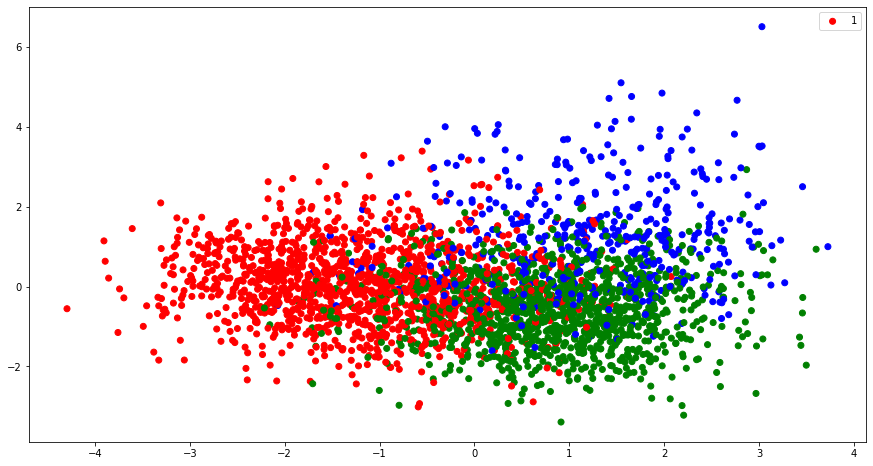

In [ ]:
#Plot LDA
plt.figure(figsize=(15, 8))
colors = {1:'red', 2:'green', 3:'blue'}
#colors = {1:'blue', 2:'red', 3:'green'}
plt.scatter(X_r2[:,0],X_r2[:,1],  c=df['Proficiency'].map(colors))
plt.legend(target_names)
plt.show()

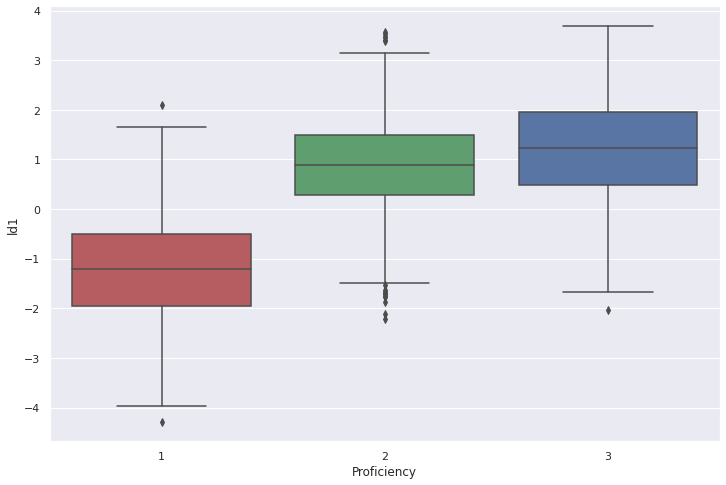

In [ ]:
# Verify LDA distribution throughout levels
df4=pd.DataFrame(zip(X_r2[:,0],X_r2[:,1],y),columns=["ld1","ld2","Proficiency"])

sns.set(rc={'figure.figsize':(12,8)})
my_pal = {1: "r", 2: "g", 3:"b"}
#subplot(2,1,1)
sns.boxplot(x='Proficiency', y='ld1', data=df4, palette=my_pal)
#subplot(2,1,2)
#sns.boxplot(x='Level', y='ld2', data=df)

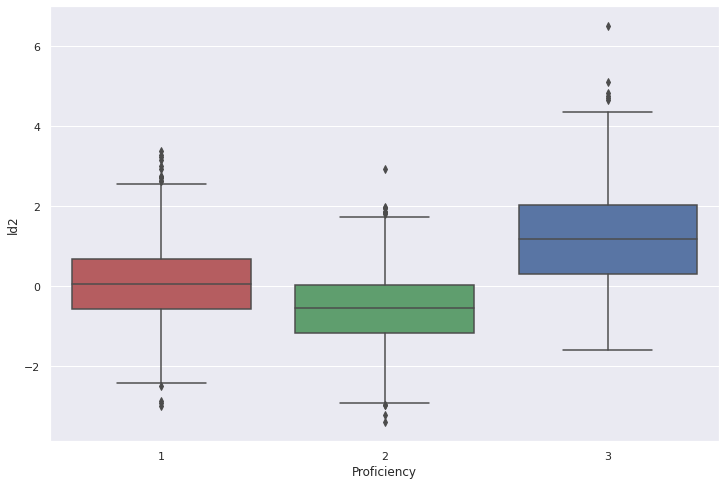

In [ ]:
# Verify LDA distribution throughout levels
df4=pd.DataFrame(zip(X_r2[:,0],X_r2[:,1],y),columns=["ld1","ld2","Proficiency"])

sns.set(rc={'figure.figsize':(12,8)})

#subplot(2,1,1)
sns.boxplot(x='Proficiency', y='ld2', data=df4, palette=my_pal)
#subplot(2,1,2)
#sns.boxplot(x='Level', y='ld2', data=df)

# **Model Explanations with SHAP**

In order to apply SHAP, the data set was cut at 500 samples, then undersampling was performed for class balancing

In [ ]:
features_names = df.columns[:-1]

In [ ]:
X = df.iloc[:500, :-1]
y = df.iloc[:500, 463]

In [ ]:
df['Proficiency'].value_counts()

1    1299
2    1197
3     457
Name: Proficiency, dtype: int64

In [ ]:
X = StandardScaler().fit_transform(X)

In [ ]:
under_sampler = RandomUnderSampler(random_state=42)
X, y = under_sampler.fit_resample(X, y)
print(f"Samples: {Counter(y)}")

Samples: Counter({1: 116, 2: 116, 3: 116})


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40, shuffle=True)

In [ ]:
svm_model = SVC(C=5, kernel='rbf', probability=True)
svm_model.fit(X_train, y_train)

SVC(C=5, probability=True)

In [ ]:
predictions = svm_model.predict(X_test)

In [ ]:
print(metrics.classification_report(y_test, predictions))

              precision    recall  f1-score   support

           1       0.92      0.92      0.92        25
           2       0.77      0.74      0.75        27
           3       0.68      0.72      0.70        18

    accuracy                           0.80        70
   macro avg       0.79      0.79      0.79        70
weighted avg       0.80      0.80      0.80        70



In [ ]:
print(metrics.confusion_matrix(y_test, predictions))

[[23  1  1]
 [ 2 20  5]
 [ 0  5 13]]


In [ ]:
# compute SHAP values
explainer = shap.KernelExplainer(svm_model.predict_proba, X_train)
shap_values = explainer.shap_values(X_test)

  0%|          | 0/70 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

* **Plot which features contributed to which class prediction**

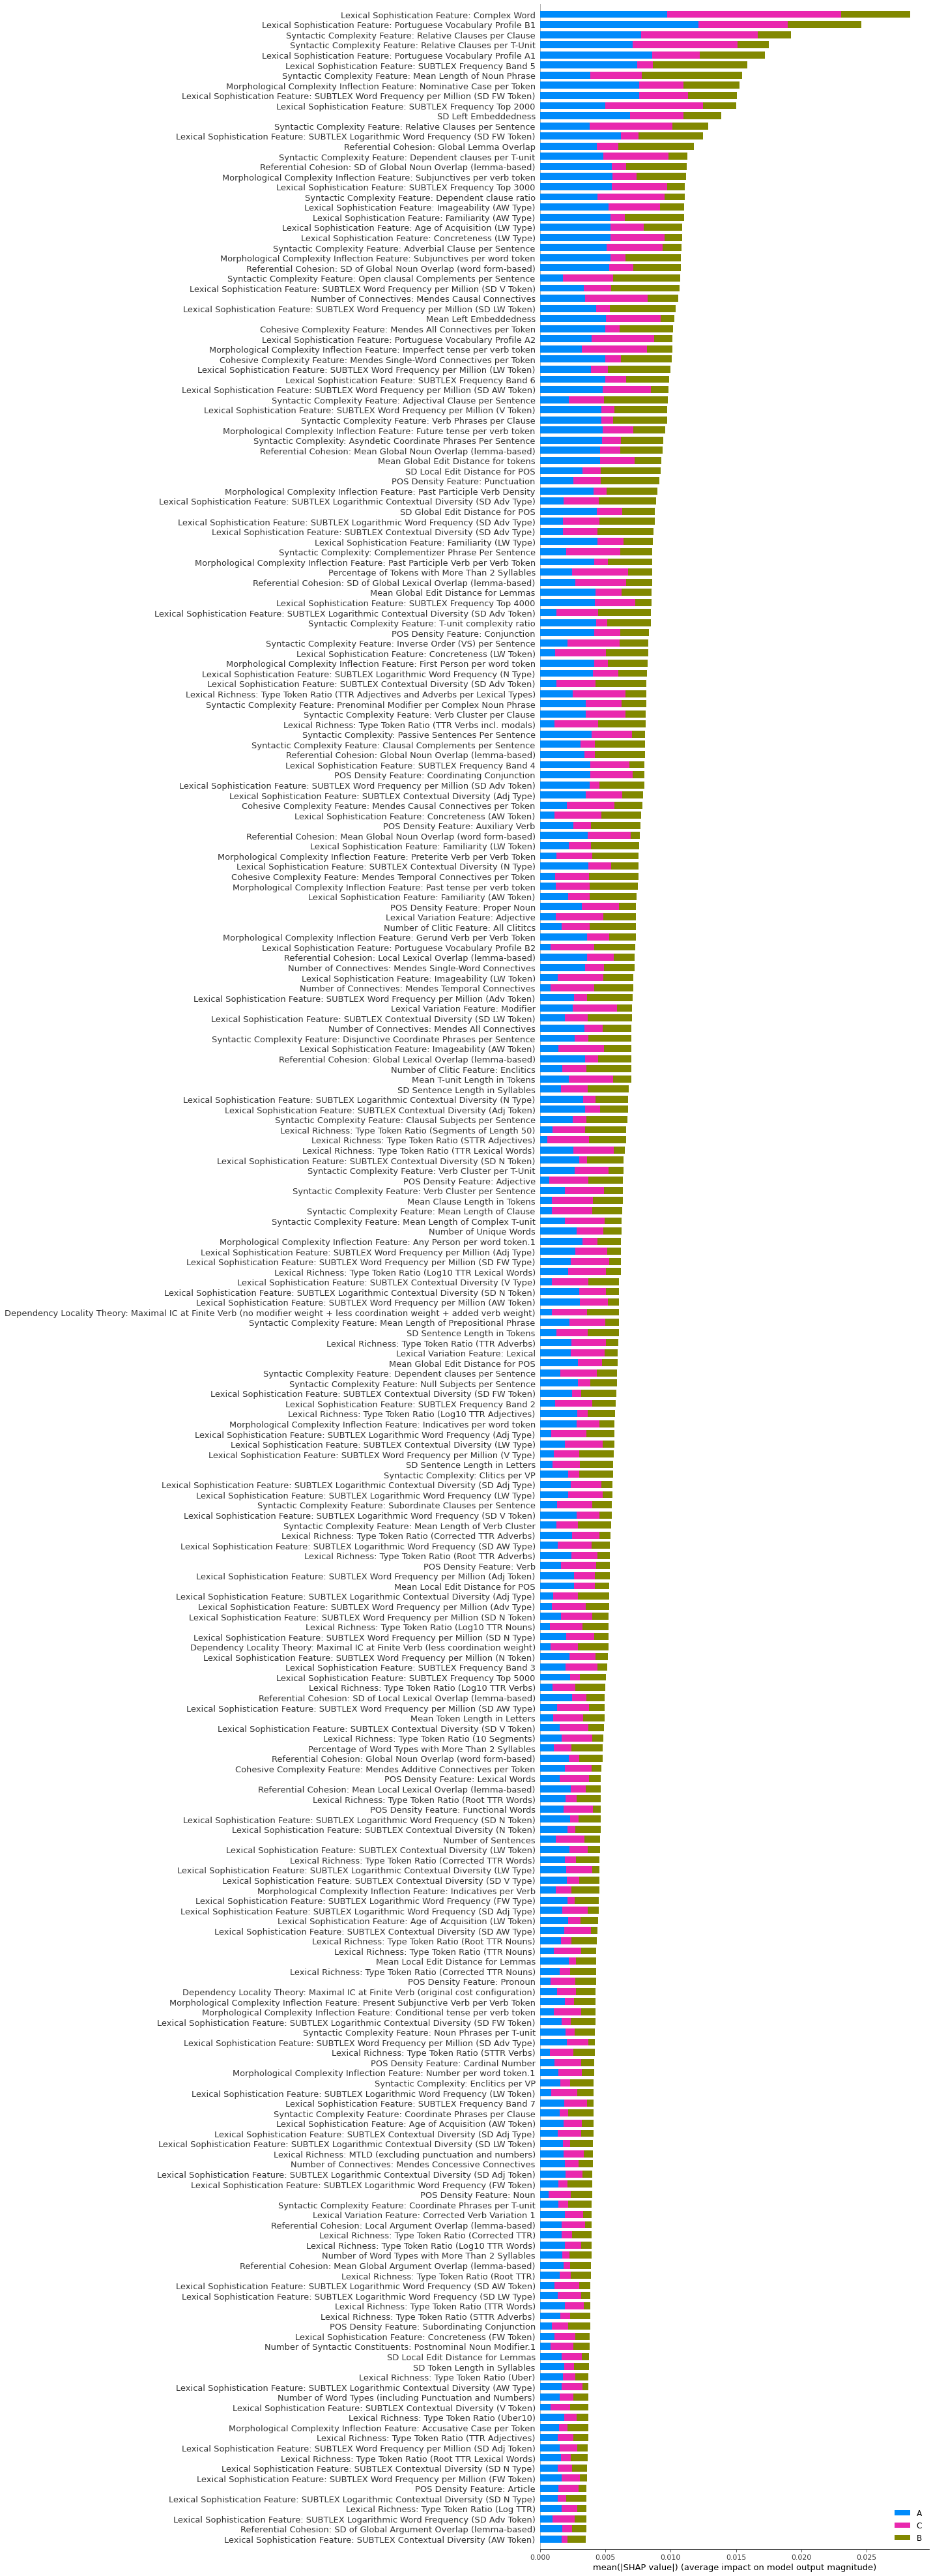

In [ ]:
# Plot of the top 250 mean SHAP values for all classes
class_names = ['A', 'B', 'C']
shap.summary_plot(shap_values, X, plot_type="bar", class_names= class_names, feature_names = features_names, plot_size=[20,55], max_display=250)

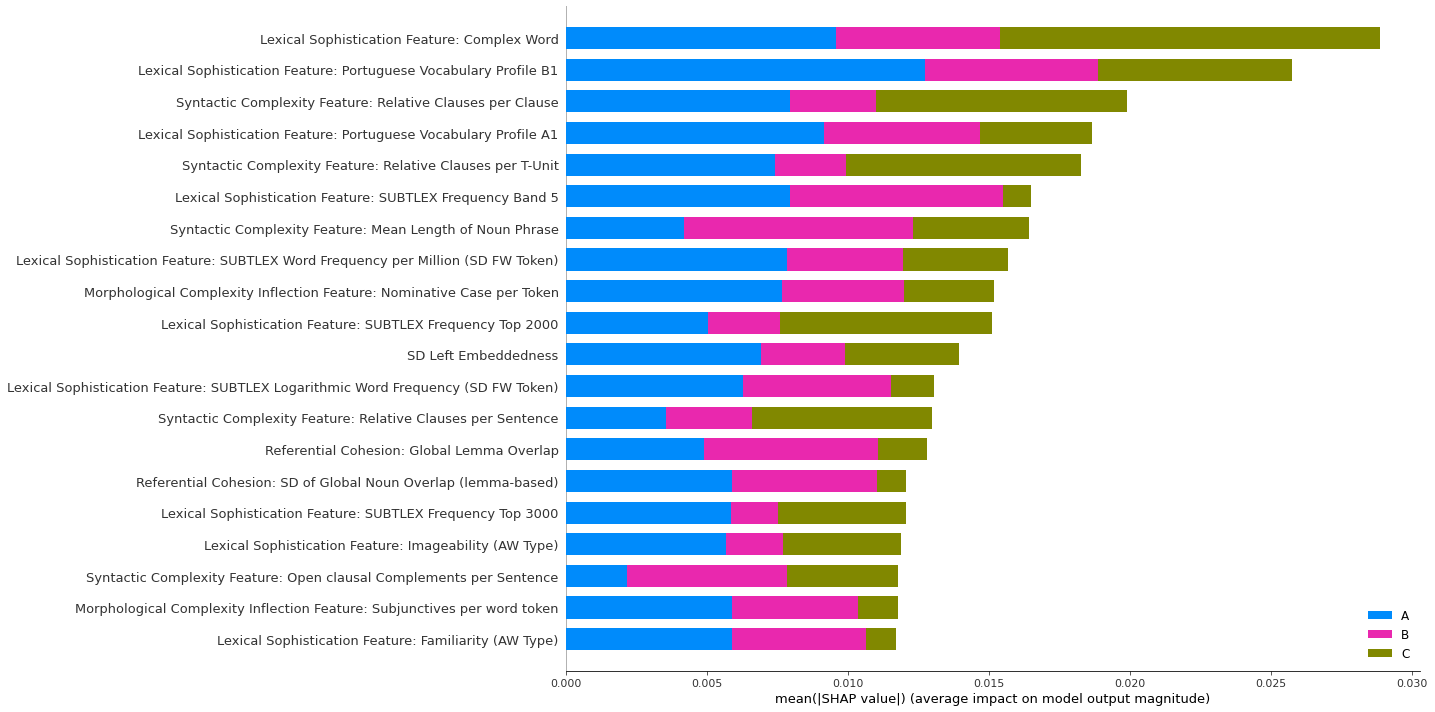

In [ ]:
# Plot of the 20 top highest mean SHAP values
class_names = ['A', 'B', 'C']
shap.summary_plot(shap_values, X, plot_type="bar", class_names= class_names, feature_names = features_names, plot_size=[20,10])

* **Plot the top 20 most important features for predicting level A**

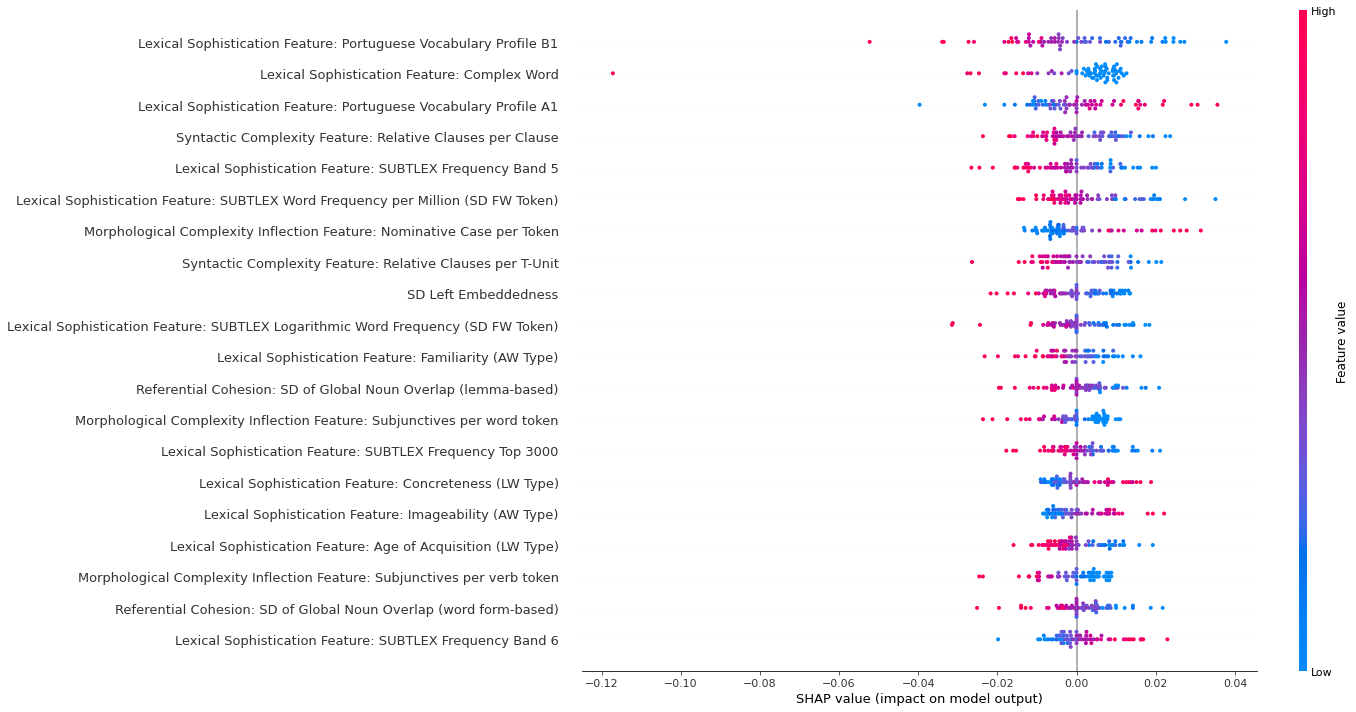

In [ ]:
shap.summary_plot(shap_values[0], X_test, feature_names = features_names, plot_size=[20,10])

* **Plot the top 20 most important features for predicting level B**

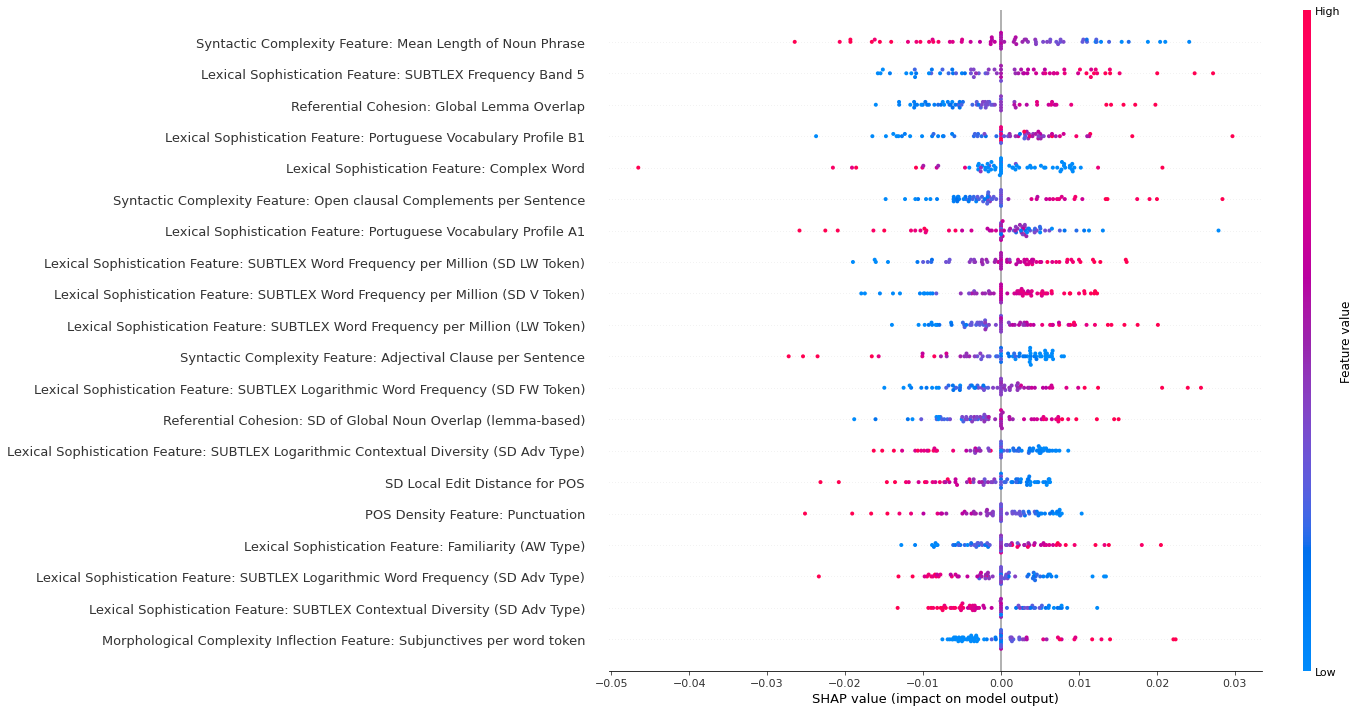

In [ ]:
shap.summary_plot(shap_values[1], X_test, feature_names = features_names, plot_size=[20,10])

* **Plot the top 20 most important features for predicting level C**

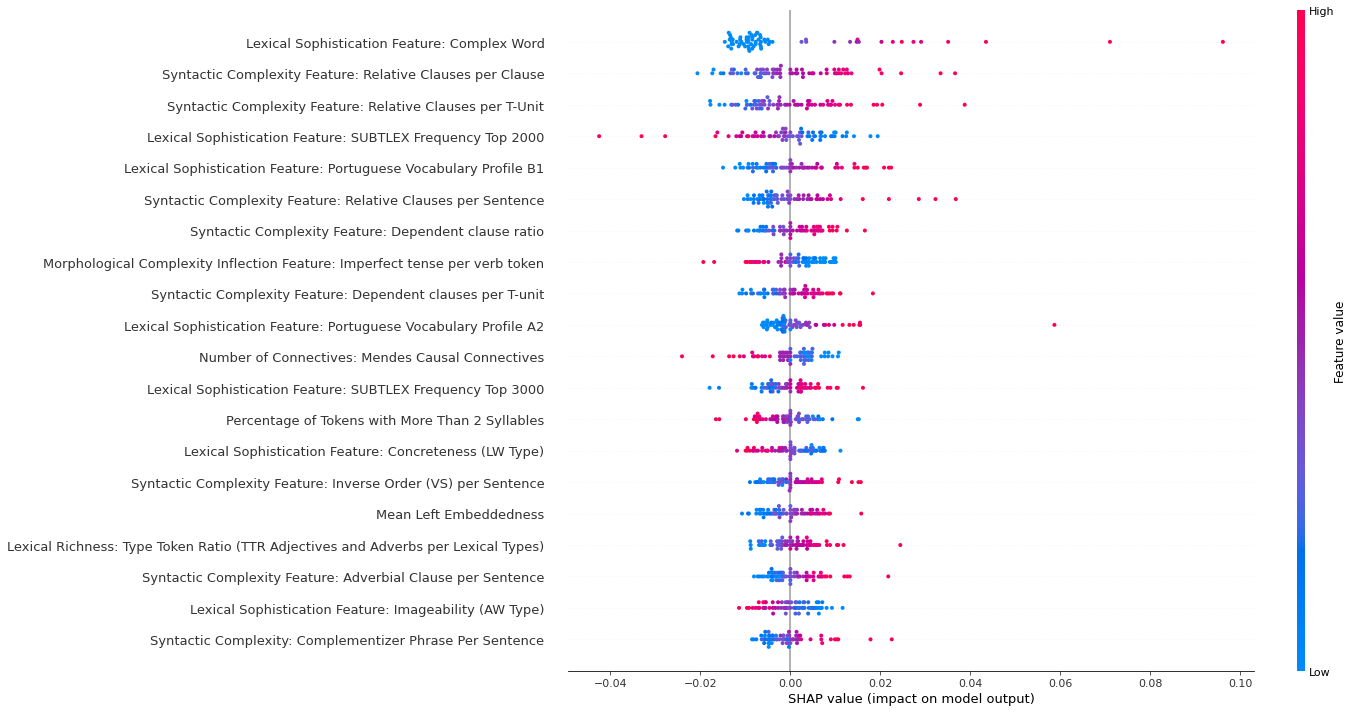

In [ ]:
shap.summary_plot(shap_values[2], X_test, feature_names = features_names, plot_size=[20,10])

# **Binary Classifiers**

## **Discriminating between A and B**

In [ ]:
# Delete level C samples
df = df[df.Proficiency != 3]

In [ ]:
df['Proficiency'].value_counts()

1    1299
2    1197
Name: Proficiency, dtype: int64

In [ ]:
df['Proficiency'] = df['Proficiency'].replace([1], 0)
df['Proficiency'] = df['Proficiency'].replace([2], 1)

In [ ]:
features_names = df.columns[:-1]

In [ ]:
svm_model = SVC(C=3, coef0=0.5, degree=3, gamma='scale', kernel='rbf', probability=True)

In [ ]:
X = df.iloc[:, :-1].values
y = df.iloc[:, 464].values

In [ ]:
X = StandardScaler().fit_transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40, shuffle=True)

In [ ]:
# 10-fold Cross validation for SVM classification
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
scores = cross_val_score(svm_model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean Accuracy: 0.805 (0.018)


In [ ]:
# 10-fold Cross validation for SVM classification
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
scores = cross_val_score(svm_model, X, y, scoring='f1_weighted', cv=cv, n_jobs=-1)
print('Weighted F1: %.3f (%.3f)' % (mean(scores), std(scores)))

Weighted F1: 0.804 (0.018)


In [ ]:
# Experiment with held-out test set
svm_model.fit(X_train, y_train)

SVC(C=3, coef0=0.5, probability=True)

In [ ]:
predictions = svm_model.predict(X_test)

In [ ]:
print(metrics.classification_report(y_test, predictions)) # Without undersampling

              precision    recall  f1-score   support

           0       0.80      0.83      0.81       252
           1       0.82      0.79      0.80       248

    accuracy                           0.81       500
   macro avg       0.81      0.81      0.81       500
weighted avg       0.81      0.81      0.81       500



In [ ]:
print(metrics.classification_report(y_test, predictions)) # With undersampling

              precision    recall  f1-score   support

           0       0.87      0.89      0.88        38
           1       0.87      0.84      0.85        31

    accuracy                           0.87        69
   macro avg       0.87      0.87      0.87        69
weighted avg       0.87      0.87      0.87        69



* **Applying SHAP in a smaller sample**

In [ ]:
X = df.iloc[:395, :-1].values
y = df.iloc[:395, 464].values

In [ ]:
X = StandardScaler().fit_transform(X)

In [ ]:
under_sampler = RandomUnderSampler(random_state=42)
X, y = under_sampler.fit_resample(X, y)
print(f"Samples: {Counter(y)}")

Samples: Counter({0: 171, 1: 171})


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40, shuffle=True)

In [ ]:
svm_model = SVC(C=3, coef0=0.5, degree=3, gamma='scale', kernel='rbf', probability=True)

SVC(C=3, coef0=0.5, probability=True)

In [ ]:
# compute SHAP values
explainer = shap.KernelExplainer(svm_model.predict_proba, X_train)
shap_values = explainer.shap_values(X_test)

  0%|          | 0/69 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

* **Density plot of top 20 most important features**

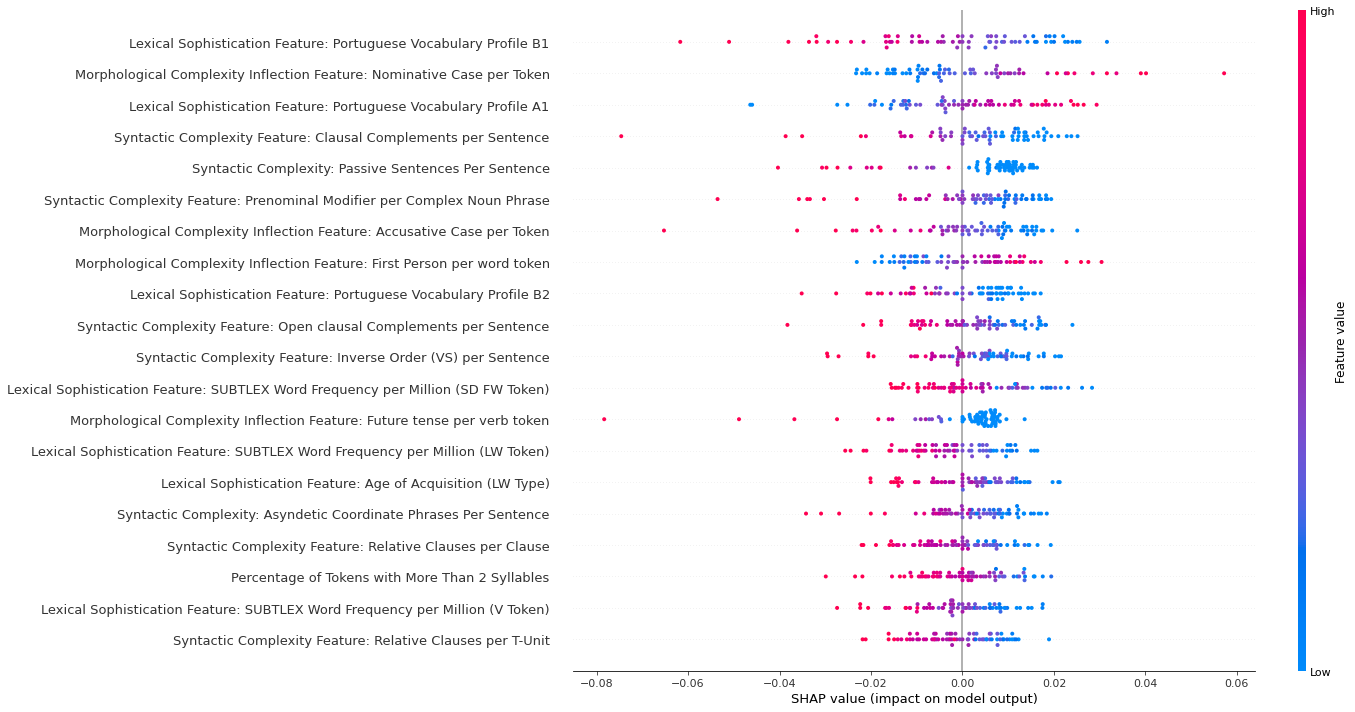

In [ ]:
# A vs B, 342 samples
shap.summary_plot(shap_values[0], X_test, feature_names = features_names, plot_size=[20,10])

## **Discriminating between B and C**

In [ ]:
# Delete level A samples
df = df[df.Proficiency != 1]

In [ ]:
df['Proficiency'].value_counts()

2    1197
3     457
Name: Proficiency, dtype: int64

In [ ]:
df['Proficiency'] = df['Proficiency'].replace([2], 0)

In [ ]:
df['Proficiency'] = df['Proficiency'].replace([3], 1)

In [ ]:
svm_model = SVC(C=3, coef0=0.5, degree=3, gamma='scale', kernel='rbf', probability=True)

In [ ]:
X = df.iloc[:, :-1].values
y = df.iloc[:, 463].values

In [ ]:
X = StandardScaler().fit_transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40, shuffle=True)

In [ ]:
# Balance data for classification
under_sampler = RandomUnderSampler(random_state=42)
X, y = under_sampler.fit_resample(X, y)
print(f"Samples: {Counter(y)}")

Samples: Counter({0: 457, 1: 457})


In [ ]:
# 10-fold Cross validation for SVM classification
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
scores = cross_val_score(svm_model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean Accuracy: 0.673 (0.036)


In [ ]:
# 10-fold Cross validation for SVM classification
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
scores = cross_val_score(svm_model, X, y, scoring='f1_weighted', cv=cv, n_jobs=-1)
print('Weighted F1: %.3f (%.3f)' % (mean(scores), std(scores)))

Weighted F1: 0.671 (0.038)


In [ ]:
svm_model.fit(X_train, y_train)

SVC(C=3, coef0=0.5, probability=True)

In [ ]:
predictions = svm_model.predict(X_test)

In [ ]:
print(metrics.classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.67      0.69      0.68        93
           1       0.67      0.64      0.66        90

    accuracy                           0.67       183
   macro avg       0.67      0.67      0.67       183
weighted avg       0.67      0.67      0.67       183



* **Apply SHAP in a smaller sample**

In [ ]:
X = df.iloc[:565, :-1].values
y = df.iloc[:565, 413].values

In [ ]:
X = StandardScaler().fit_transform(X)

In [ ]:
under_sampler = RandomUnderSampler(random_state=42)
X, y = under_sampler.fit_resample(X, y)
print(f"Samples: {Counter(y)}")

Samples: Counter({0: 170, 1: 170})


In [ ]:
svm_model = SVC(C=3, coef0=0.5, degree=3, gamma='scale', kernel='rbf', probability=True)
svm_model.fit(X_train, y_train)

SVC(C=3, coef0=0.5, probability=True)

In [ ]:
# compute SHAP values
explainer = shap.KernelExplainer(svm_model.predict_proba, X_train)
shap_values = explainer.shap_values(X_test)

  0%|          | 0/71 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

* **Density plot of top 20 features**

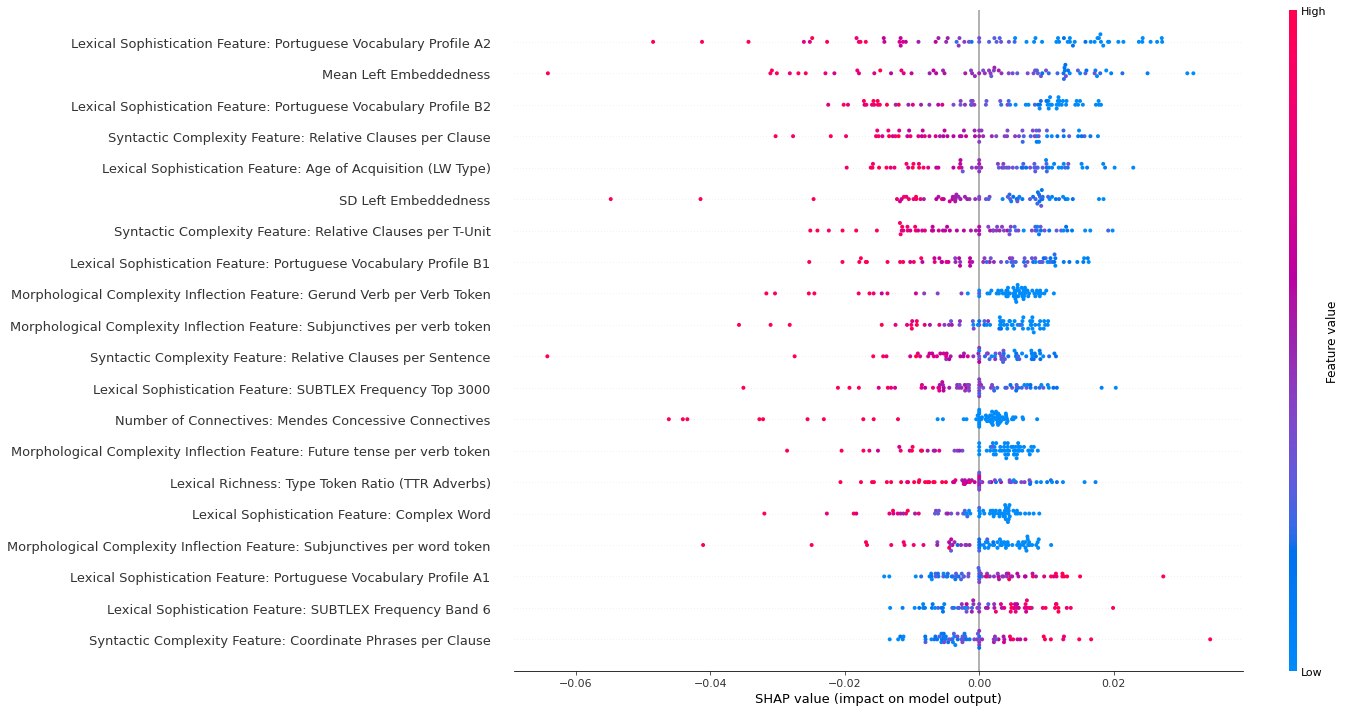

In [ ]:
# B vs C, 240 samples
shap.summary_plot(shap_values[0], X_test, feature_names = features_names, plot_size=[20,10])

## **Discriminating between A and C**

In [ ]:
features_names = df.columns[:-1]

In [ ]:
# Delete level B samples
df = df[df.Proficiency != 2]

In [ ]:
df['Proficiency'].value_counts()

1    1299
3     457
Name: Proficiency, dtype: int64

In [ ]:
df['Proficiency'] = df['Proficiency'].replace([1], 0)

In [ ]:
df['Proficiency'] = df['Proficiency'].replace([3], 1)

In [ ]:
X = df.iloc[:, :-1].values
y = df.iloc[:, 463].values

In [ ]:
X = StandardScaler().fit_transform(X)

In [ ]:
# Balance data for classification
under_sampler = RandomUnderSampler(random_state=42)
X, y = under_sampler.fit_resample(X, y)
print(f"Samples: {Counter(y)}")

Samples: Counter({0: 457, 1: 457})


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40, shuffle=True)

In [ ]:
svm_model = SVC(C=3, coef0=0.5, degree=3, gamma='scale', kernel='rbf', probability=True)

In [ ]:
# Cross validation for SVM classification
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
scores = cross_val_score(svm_model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean Accuracy: 0.794 (0.034)


In [ ]:
# Cross validation for SVM classification
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
scores = cross_val_score(svm_model, X, y, scoring='f1_weighted', cv=cv, n_jobs=-1)
print('Weighted F1: %.3f (%.3f)' % (mean(scores), std(scores)))

Weighted F1: 0.793 (0.034)


In [ ]:
svm_model.fit(X_train, y_train)

SVC(C=3, coef0=0.5, probability=True)

In [ ]:
predictions = svm_model.predict(X_test)

In [ ]:
print(metrics.classification_report(y_test, predictions)) # With undersampling

              precision    recall  f1-score   support

           0       0.79      0.83      0.81        93
           1       0.81      0.77      0.79        90

    accuracy                           0.80       183
   macro avg       0.80      0.80      0.80       183
weighted avg       0.80      0.80      0.80       183



* **Apply SHAP in smaller sample**

In [ ]:
X = df.iloc[:480, :-1].values
y = df.iloc[:480, 463].values

In [ ]:
X = StandardScaler().fit_transform(X)

In [ ]:
# Balance class distribution
under_sampler = RandomUnderSampler(random_state=42)
X, y = under_sampler.fit_resample(X, y)
print(f"Samples: {Counter(y)}")

Samples: Counter({0: 176, 1: 176})


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40, shuffle=True)

In [ ]:
svm_model = SVC(C=3, coef0=0.5, degree=3, gamma='scale', kernel='rbf', probability=True)

SVC(C=3, coef0=0.5, probability=True)

In [ ]:
# compute SHAP values
explainer = shap.KernelExplainer(svm_model.predict_proba, X_train)
shap_values = explainer.shap_values(X_test)

  0%|          | 0/71 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

* **Density plot of top 20 most important features**

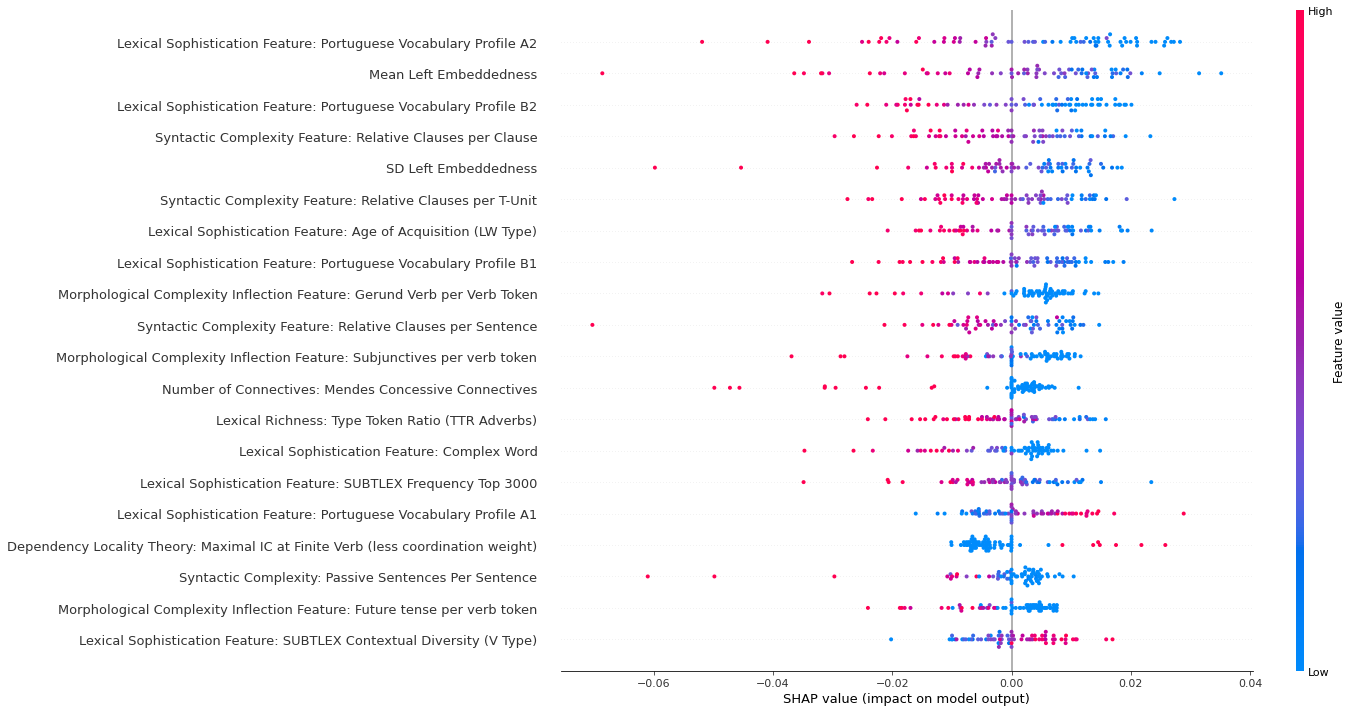

In [ ]:
# A vs C, 172 samples
shap.summary_plot(shap_values[0], X_test, feature_names = features_names, plot_size=[20,10])